<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_6/Tugas_6_PyTorch%26Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tugas 6
1. Buat model Deep learning (PyTorch and Tensorflow).
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC). Visualisasikan matriks akurasi dan loss.
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 70%.
5. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan
     T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

### Import Dataset dan Setup Awal

In [35]:
# Cek dan aktifkan GPU jika tersedia
import tensorflow as tf

# Cek TensorFlow
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available:  []


In [36]:

# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import nltk
from nltk.corpus import stopwords
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Download resource untuk NLP
!pip install nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Preprocessing Dataset

In [37]:
# Load dataset
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
import requests

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Path dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)
data_path = '/content/DeteksiSarkasme.json'

if response.status_code == 200:
    with open(data_path, 'wb') as f:
        f.write(response.content)
    print(f"Dataset berhasil diunduh ke: {data_path}")
else:
    print(f"Terjadi kesalahan saat mengunduh file. Status code: {response.status_code}")

print("📥 Memuat dataset dari:", data_path)
data = pd.read_json(data_path, lines=True)

print("Jumlah data sebelum preprocessing:", len(data))
print("Kolom yang tersedia:", data.columns.tolist())

# Preprocessing
def bersihkan_teks(teks):
    if pd.isnull(teks):
        return ""
    teks = teks.lower()
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = re.sub(r'\d+', '', teks)
    teks = re.sub(r'\s+', ' ', teks).strip()
    tokens = teks.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

print("\n🔧 Melakukan preprocessing pada teks ulasan...")
data['Cleaned Review'] = data['headline'].apply(bersihkan_teks)

# Preview
print("\n🧾 Contoh hasil sebelum dan sesudah dibersihkan:")
for idx in range(3):
    original = data['headline'].iloc[idx][:100]
    cleaned = data['Cleaned Review'].iloc[idx][:100]
    print(f"\nsebelum  : {original}...")
    print(f"Sesudah   : {cleaned}...")

# Statistik panjang kalimat
data['length'] = data['Cleaned Review'].apply(lambda x: len(x.split()))
print("\n📏 Statistik panjang kalimat (jumlah kata):")
print(data['length'].describe())


Dataset berhasil diunduh ke: /content/DeteksiSarkasme.json
📥 Memuat dataset dari: /content/DeteksiSarkasme.json
Jumlah data sebelum preprocessing: 26709
Kolom yang tersedia: ['article_link', 'headline', 'is_sarcastic']

🔧 Melakukan preprocessing pada teks ulasan...

🧾 Contoh hasil sebelum dan sesudah dibersihkan:

sebelum  : former versace store clerk sues over secret 'black code' for minority shoppers...
Sesudah   : former versace store clerk sues secret black code minority shoppers...

sebelum  : the 'roseanne' revival catches up to our thorny political mood, for better and worse...
Sesudah   : roseanne revival catches thorny political mood better worse...

sebelum  : mom starting to fear son's web series closest thing she will have to grandchild...
Sesudah   : mom starting fear sons web series closest thing grandchild...

📏 Statistik panjang kalimat (jumlah kata):
count    26709.000000
mean         6.984724
std          2.269902
min          0.000000
25%          5.000000
50%       

In [38]:
from sklearn.model_selection import train_test_split

# Pilih fitur dan label
fitur = data['Cleaned Review']
label = data['is_sarcastic']

# Bagi data menjadi training dan testing set
X_latih, X_uji, y_latih, y_uji = train_test_split(
    fitur, label, test_size=0.2, random_state=42, stratify=label
)

# Reset index (supaya aman untuk indexing & tokenisasi selanjutnya)
X_latih = X_latih.reset_index(drop=True)
X_uji = X_uji.reset_index(drop=True)
y_latih = y_latih.reset_index(drop=True)
y_uji = y_uji.reset_index(drop=True)

# Tampilkan informasi distribusi
print(f"\n📊 Jumlah data latih: {len(X_latih)}")
print(f"📊 Jumlah data uji: {len(X_uji)}")
print(f"🔍 Distribusi label (Training): {y_latih.value_counts().to_dict()}")
print(f"🔍 Distribusi label (Testing): {y_uji.value_counts().to_dict()}")

# Contoh sanity check
print("\n🧾 Contoh data latih:")
print("Teks:", X_latih.iloc[0])
print("Label:", y_latih.iloc[0])



📊 Jumlah data latih: 21367
📊 Jumlah data uji: 5342
🔍 Distribusi label (Training): {0: 11988, 1: 9379}
🔍 Distribusi label (Testing): {0: 2997, 1: 2345}

🧾 Contoh data latih:
Teks: fbi raids fridge
Label: 1


In [39]:
from collections import Counter

def buat_kamus_kata(daftar_teks, batas_vocab=10000):
    # Gabungkan semua kalimat dan pecah menjadi kata
    semua_kata = ' '.join(daftar_teks).split()

    # Hitung frekuensi setiap kata
    frekuensi_kata = Counter(semua_kata)

    # Ambil kata yang paling sering muncul (dikurangi token khusus)
    kata_teratas = frekuensi_kata.most_common(batas_vocab - 2)

    # Inisialisasi kamus dengan token spesial
    kamus = {'<PAD>': 0, '<UNK>': 1}
    for kata, _ in kata_teratas:
        kamus[kata] = len(kamus)

    return kamus

print("🔠 Sedang membuat kamus kata dari data latih...")
kamus_kata = buat_kamus_kata(X_latih, batas_vocab=10000)
ukuran_kamus = len(kamus_kata)
print(f"📚 Total kata dalam kamus: {ukuran_kamus}")

# Tampilkan sebagian isi kamus
print("\n📌 Contoh 20 entri pertama dalam kamus:")
for i, (kata, indeks) in enumerate(kamus_kata.items()):
    if i >= 10:
        break
    print(f"{kata}: {indeks}")


🔠 Sedang membuat kamus kata dari data latih...
📚 Total kata dalam kamus: 10000

📌 Contoh 20 entri pertama dalam kamus:
<PAD>: 0
<UNK>: 1
new: 2
man: 3
trump: 4
us: 5
one: 6
report: 7
area: 8
day: 9


In [40]:
import numpy as np

# Fungsi konversi teks ke sequence angka
def ubah_teks_ke_sequence(teks, kamus, panjang_maks=100):
    # Pecah teks menjadi daftar kata
    tokens = teks.split()

    # Ubah tiap kata menjadi indeks dari kamus, jika tidak ditemukan pakai <UNK>
    hasil_sequence = [kamus.get(kata, kamus['<UNK>']) for kata in tokens[:panjang_maks]]

    # Tambahkan padding jika panjang belum cukup
    if len(hasil_sequence) < panjang_maks:
        hasil_sequence += [kamus['<PAD>']] * (panjang_maks - len(hasil_sequence))

    return hasil_sequence

# Tentukan panjang sequence maksimal
panjang_sequence = 100

# Proses seluruh data teks menjadi sequence angka
print(f"🔁 Mengubah teks menjadi urutan angka dengan panjang {panjang_sequence}...")
X_latih_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_latih])
X_uji_seq = np.array([ubah_teks_ke_sequence(teks, kamus_kata, panjang_sequence) for teks in X_uji])

# Info bentuk hasil
print(f"✅ X_latih_seq shape: {X_latih_seq.shape}")
print(f"✅ X_uji_seq shape: {X_uji_seq.shape}")

# Simpan hasil preprocessing ke file
print("\n💾 Menyimpan data hasil preprocessing...")
np.save('X_latih_seq.npy', X_latih_seq)
np.save('X_uji_seq.npy', X_uji_seq)
np.save('y_latih.npy', y_latih.values)
np.save('y_uji.npy', y_uji.values)

# Contoh hasil konversi
print("\n🧾 Contoh hasil sequence dari salah satu review:")
print(f"Teks asli: {X_latih.iloc[0][:50]}...")
print(f"Sequence: {X_latih_seq[0][:20]}...")


🔁 Mengubah teks menjadi urutan angka dengan panjang 100...
✅ X_latih_seq shape: (21367, 100)
✅ X_uji_seq shape: (5342, 100)

💾 Menyimpan data hasil preprocessing...

🧾 Contoh hasil sequence dari salah satu review:
Teks asli: fbi raids fridge...
Sequence: [ 473 4188 4189    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]...


### Tensorflow/Keras


### Proses Training RNN Models

In [21]:
import numpy as np

# Memuat data yang sudah diproses
X_latih_seq = np.load('X_latih_seq.npy')
X_uji_seq = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')

print(f"Shape X_latih_seq: {X_latih_seq.shape}")
print(f"Shape X_uji_seq: {X_uji_seq.shape}")
print(f"Shape y_latih: {y_latih.shape}")
print(f"Shape y_uji: {y_uji.shape}")


Shape X_latih_seq: (21367, 100)
Shape X_uji_seq: (5342, 100)
Shape y_latih: (21367,)
Shape y_uji: (5342,)


In [22]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall

# Parameter model
input_length = 100
vocab_size = 10000  # Sesuai kamus yang kamu buat
embedding_dim = 128
rnn_units = 64
output_units = 1
dropout_rate = 0.2

# Arsitektur model
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    tf.keras.layers.SimpleRNN(rnn_units, dropout=dropout_rate, return_sequences=False),
    tf.keras.layers.Dense(output_units, activation='sigmoid')
])

# Kompilasi model
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Ringkasan
model_rnn.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model_rnn.fit(
    X_latih_seq, y_latih,
    epochs=30,
    batch_size=64,
    validation_data=(X_uji_seq, y_uji)
)


Epoch 1/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.5487 - auc: 0.5049 - loss: 0.6890 - precision: 0.4257 - recall: 0.0664 - val_accuracy: 0.6612 - val_auc: 0.7212 - val_loss: 0.6567 - val_precision: 0.6040 - val_recall: 0.6623
Epoch 2/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6877 - auc: 0.7205 - loss: 0.6054 - precision: 0.6762 - recall: 0.5605 - val_accuracy: 0.7613 - val_auc: 0.7919 - val_loss: 0.5407 - val_precision: 0.7267 - val_recall: 0.7313
Epoch 3/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8024 - auc: 0.8368 - loss: 0.4790 - precision: 0.7650 - recall: 0.7974 - val_accuracy: 0.7490 - val_auc: 0.7750 - val_loss: 0.5563 - val_precision: 0.7134 - val_recall: 0.7156
Epoch 4/30
334/334 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8339 - auc: 0.8751 - loss: 0.4261 - precision: 0.8249 - recall: 0.7916 - val_accuracy: 0.7666 - val_auc: 0.8302 - val_loss: 0.5225 - val_precision: 0.7370 - val_recall: 0.7279
Epoch 5/30
334/334 ━━━━━

In [24]:
model_rnn.save('model_rnn.h5')
print("💾 Model berhasil disimpan!")


💾 Model berhasil disimpan!


In [26]:
from sklearn.metrics import classification_report

# Prediksi
y_pred_prob = model_rnn.predict(X_uji_seq)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Laporan klasifikasi
print("\n📊 Evaluasi Model:")
print(classification_report(y_uji, y_pred, digits=4))

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

📊 Evaluasi Model:
              precision    recall  f1-score   support

           0     0.7878    0.6800    0.7299      2997
           1     0.6519    0.7659    0.7043      2345

    accuracy                         0.7177      5342
   macro avg     0.7198    0.7229    0.7171      5342
weighted avg     0.7281    0.7177    0.7187      5342



In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi probabilitas
y_pred_prob = model_rnn.predict(X_uji_seq)
# Binerkan probabilitas menjadi 0 atau 1
y_pred = (y_pred_prob >= 0.5).astype(int)

# Hitung metrik evaluasi
akurasi = accuracy_score(y_uji, y_pred)
presisi = precision_score(y_uji, y_pred)
recall = recall_score(y_uji, y_pred)
f1 = f1_score(y_uji, y_pred)
auc = roc_auc_score(y_uji, y_pred_prob)

print("\n📊 Matriks Evaluasi Model RNN:")
print(f"Akurasi  : {akurasi:.4f}")
print(f"Presisi  : {presisi:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

📊 Matriks Evaluasi Model RNN:
Akurasi  : 0.7177
Presisi  : 0.6519
Recall   : 0.7659
F1 Score : 0.7043
AUC      : 0.7850


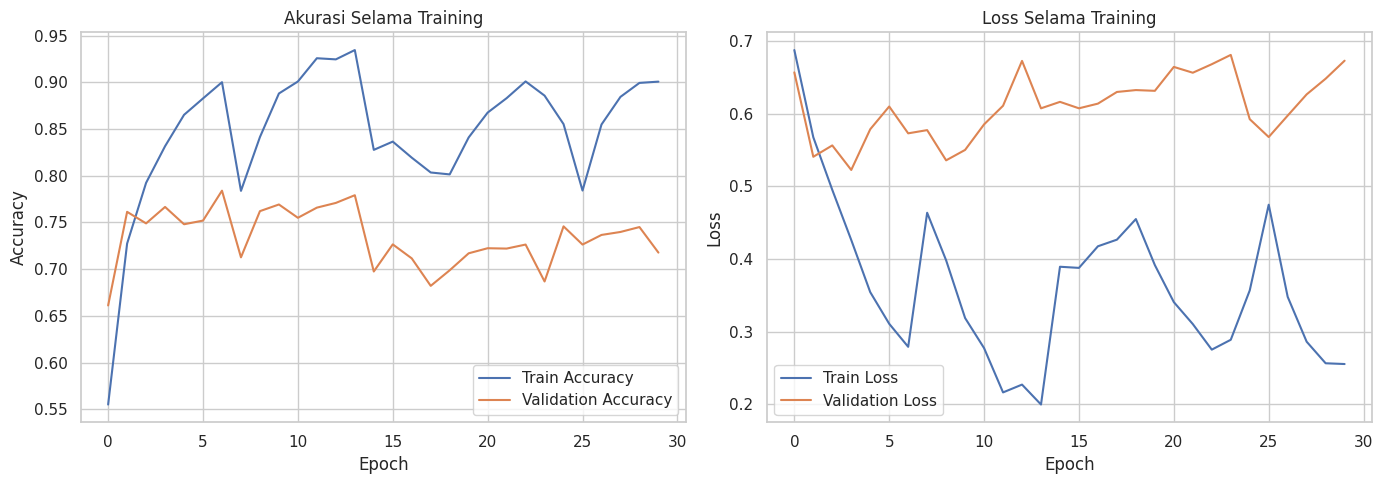

In [28]:
# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

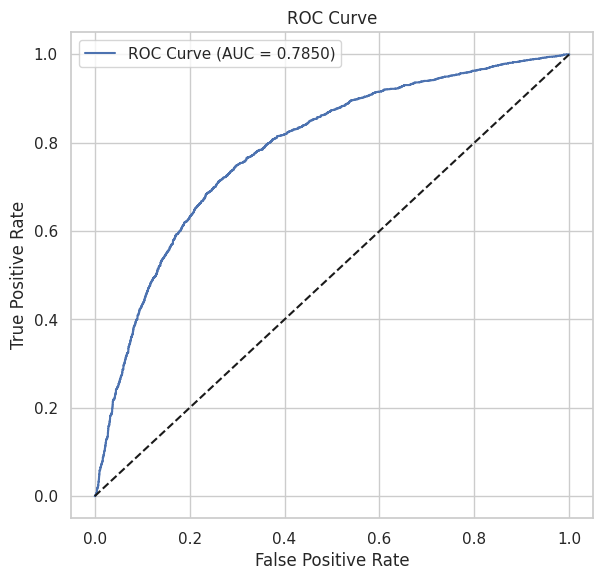

In [29]:
# Hitung nilai fpr, tpr untuk ROC curve
fpr, tpr, thresholds = roc_curve(y_uji, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # garis diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


### Hyperparameter Tuning (Tensorflow)

In [45]:
!pip install -q -U keras-tuner


In [46]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC, Precision, Recall

# Fungsi model untuk Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()

    # Hyperparameter tuning untuk jumlah unit di layer embedding dan RNN
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=hp.Int('embedding_dim', min_value=32, max_value=256, step=32), input_length=input_length))

    model.add(layers.SimpleRNN(
        units=hp.Int('rnn_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1),
        return_sequences=False))

    # Layer Dense untuk output
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(), Precision(), Recall()]
    )

    return model

In [47]:
# Inisialisasi Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Maksimalkan akurasi validasi
    max_epochs=10,  # Kurangi epoch menjadi 10
    factor=3,
    directory='tuner_results',
    project_name='sarcasm_classification'
)


In [48]:
# Melakukan pencarian hyperparameter
tuner.search(X_latih_seq, y_latih, validation_data=(X_uji_seq, y_uji), epochs=10, batch_size=64)

Trial 30 Complete [00h 11m 50s]
val_accuracy: 0.5675776600837708

Best val_accuracy So Far: 0.7880943417549133
Total elapsed time: 01h 05m 08s


In [52]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# WAJIB compile ulang sebelum retrain
from tensorflow.keras.metrics import AUC, Precision, Recall

best_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

# Retrain untuk ambil history
history = best_model.fit(
    X_latih_seq, y_latih,
    epochs=10,
    batch_size=64,
    validation_data=(X_uji_seq, y_uji),
    verbose=1
)

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.8764 - auc_1: 0.9335 - loss: 0.3194 - precision_1: 0.8610 - recall_1: 0.8586 - val_accuracy: 0.7924 - val_auc_1: 0.8520 - val_loss: 0.5320 - val_precision_1: 0.7621 - val_recall_1: 0.7663
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.8941 - auc_1: 0.9502 - loss: 0.2775 - precision_1: 0.8735 - recall_1: 0.8890 - val_accuracy: 0.7911 - val_auc_1: 0.8468 - val_loss: 0.5740 - val_precision_1: 0.7654 - val_recall_1: 0.7557
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9155 - auc_1: 0.9632 - loss: 0.2360 - precision_1: 0.9091 - recall_1: 0.8984 - val_accuracy: 0.7849 - val_auc_1: 0.8447 - val_loss: 0.6000 - val_precision_1: 0.7547 - val_recall_1: 0.7557
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.9265 - auc_1: 0.9718 - loss: 0.2046 - precision_1: 0.9217 - recall_1: 0.9107 - val_accuracy: 0.7787 - val_auc_1: 0.8353 - val_loss: 0.5858 - val_precision_1: 0.7438

In [53]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluasi pada data uji
loss, accuracy, auc_score, precision, recall = best_model.evaluate(X_uji_seq, y_uji)

# Prediksi probabilitas
y_pred_proba = best_model.predict(X_uji_seq)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Hitung F1 dan ROC AUC secara manual
f1 = f1_score(y_uji, y_pred_binary)
roc_auc = roc_auc_score(y_uji, y_pred_proba)
fpr, tpr, _ = roc_curve(y_uji, y_pred_proba)

# Tampilkan hasil evaluasi
print("\n📊 Matriks Evaluasi Model RNN:")
print(f"Akurasi  : {accuracy:.4f}")
print(f"Presisi  : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7770 - auc_1: 0.7962 - loss: 0.7528 - precision_1: 0.7632 - recall_1: 0.7146
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step

📊 Matriks Evaluasi Model RNN:
Akurasi  : 0.7769
Presisi  : 0.7563
Recall   : 0.7254
F1 Score : 0.7405
AUC      : 0.8007


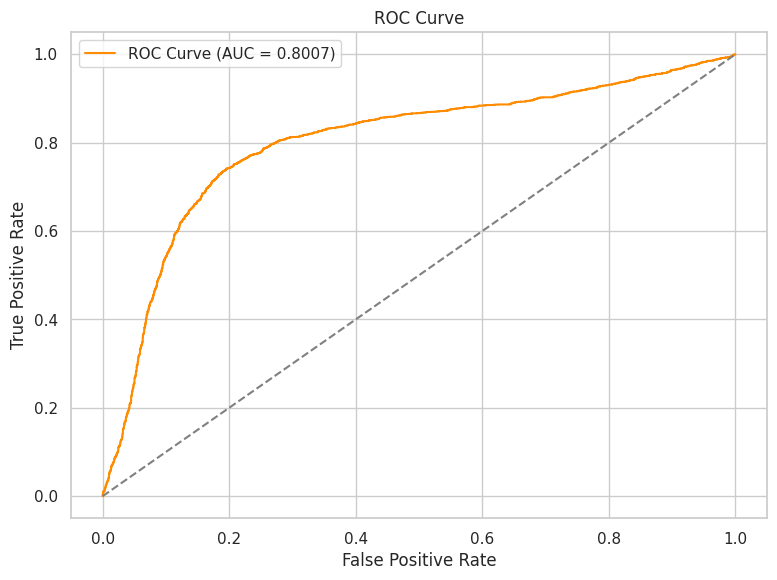

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


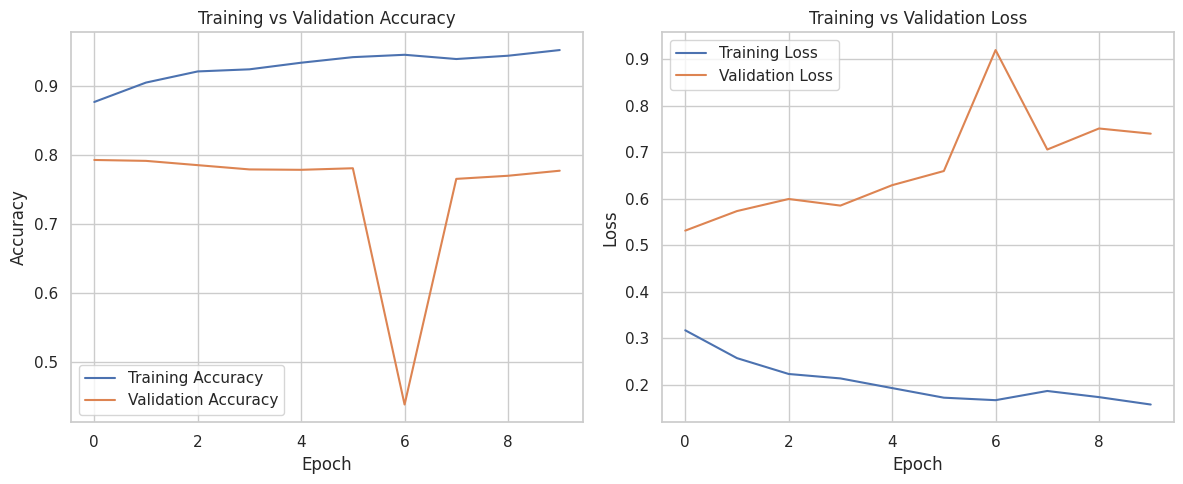

In [55]:
history_dict = history.history

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


---

## 🔁 Urutan Lengkap: Dari Keras Tuner Sampai Evaluasi Model

Bayangin **lagi ikut lomba bikin mobil tercepat**:
- Punya banyak **komponen** (mesin, ban, dll).
- Tapi belum tahu kombinasi terbaiknya (berapa cc mesin, model sasis, dll).

---

### 1. 🔍 **Keras Tuner = Montir Otomatis**
> Dia yang nyobain berbagai kombinasi mesin, sasis, dll.
```python
tuner = RandomSearch(
    build_model,  # fungsi pembuat model dengan hp
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='rnn_tuner'
)
tuner.search(X_latih_seq, y_latih, validation_data=(X_valid_seq, y_valid), epochs=10, callbacks=[stop_early])
```

📌 *Hasilnya:* tuner nyimpen semua kombinasi yang dicoba, dan tahu mana yang paling bagus.

---

### 2. ✅ **Ambil Model Terbaik**
```python
best_model = tuner.get_best_models(num_models=1)[0]
```

> Ini kayak bilang: “Oke, ambilin mobil (model) yang paling ngebut dari semua yang udah dicoba.”

🛑 **TAPI... model ini belum dilatih serius.**  
Cuma dipakai buat *uji coba cepat* selama tuning (10 epoch per trial, kecil-kecilan).

---

### 3. 🧪 **Model Harus Dicomplie Lagi**
```python
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(), Precision(), Recall()])
```

Kenapa?
> Soalnya kadang saat `get_best_models()`, modelnya belum 100% siap buat dipakai ulang (terutama di luar tuning).

---

### 4. 🔁 **Latih Ulang (Full Training, Seriusan)**
```python
history = best_model.fit(X_latih_seq, y_latih,
                         validation_data=(X_valid_seq, y_valid),
                         epochs=10, batch_size=32)
```

Ini penting, karena:
- Sekarang punya **arsitektur dan hyperparameter terbaik** dari tuning.
- Tapi butuh **melatih dari awal lagi** (dengan data training penuh) supaya hasil akhirnya bagus dan bisa divisualisasikan (`history`).

---

### 5. 📈 **Baru Evaluasi + Visualisasi**
Setelah itu baru:
- Evaluasi akurasi, presisi, recall, dll
- Visualisasi akurasi/loss
- ROC curve
- Prediksi di data uji

---

## 🔁 Kesimpulan Sederhana:

| Tahap | Tujuan |
|------|--------|
| `tuner.search(...)` | Cari kombinasi terbaik |
| `tuner.get_best_models(1)[0]` | Ambil model terbaik |
| `best_model.compile(...)` | Siapkan model untuk dilatih |
| `best_model.fit(...)` | Latih ulang pakai data kamu |
| `evaluate`, `predict`, `plot` | Tampilkan dan nilai performanya |

---

### Proses Training LSTM Models Tensorflow

In [67]:
import requests
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Path dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
data_path = '/content/DeteksiSarkasme.json'

# Mengunduh file
response = requests.get(url)
if response.status_code == 200:
    with open(data_path, 'wb') as f:
        f.write(response.content)
    print(f"Dataset berhasil diunduh ke: {data_path}")
else:
    print(f"Terjadi kesalahan saat mengunduh file. Status code: {response.status_code}")

# Membaca dataset dari file yang telah diunduh
data = pd.read_json(data_path, lines=True)

# Menyiapkan data input (X) dan label (y)
X = data['headline']  # Ambil kolom 'headline' sebagai teks input
y = data['is_sarcastic']  # Ambil kolom 'is_sarcastic' sebagai label (0 atau 1)

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000)  # Maksimal 10,000 kata yang dipertimbangkan
tokenizer.fit_on_texts(X)

# Ubah teks menjadi sequence angka
X_seq = tokenizer.texts_to_sequences(X)

# Padding sequence agar panjangnya seragam (misalnya panjang maksimal 100)
X_seq_padded = pad_sequences(X_seq, maxlen=100)  # Sesuaikan maxlen dengan panjang input yang diinginkan

# Membagi data menjadi training dan validation set
X_train, X_val, y_train, y_val = train_test_split(X_seq_padded, y, test_size=0.2, random_state=42)

# Sekarang X_train, X_val, y_train, y_val sudah siap digunakan untuk pelatihan



Dataset berhasil diunduh ke: /content/DeteksiSarkasme.json


In [68]:
import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel, RandomSearch

class LSTMHyperModel(HyperModel):
    def __init__(self, vocab_size, maxlen):
        self.vocab_size = vocab_size
        self.maxlen = maxlen

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=hp.Int('embedding_dim', min_value=16, max_value=128, step=16),
            input_length=self.maxlen
        ))
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True))
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
        )

        return model


In [69]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = X_train.shape[1]

tuner = RandomSearch(
    LSTMHyperModel(vocab_size, maxlen),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)


Reloading Tuner from my_dir/lstm_tuning/tuner0.json


In [70]:
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Trial 10 Complete [00h 42m 32s]
val_accuracy: 0.8584799766540527

Best val_accuracy So Far: 0.8603519201278687
Total elapsed time: 04h 02m 52s


In [75]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ambil model terbaik
best_model = tuner.get_best_models(1)[0]

# 2. Compile ulang (biasanya perlu)
best_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Latih ulang model terbaik (agar dapat history training untuk visualisasi)
history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 224s 327ms/step - accuracy: 0.9223 - loss: 0.1906 - val_accuracy: 0.8615 - val_loss: 0.4301
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 212s 317ms/step - accuracy: 0.9409 - loss: 0.1545 - val_accuracy: 0.8613 - val_loss: 0.5045
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 263s 319ms/step - accuracy: 0.9637 - loss: 0.0990 - val_accuracy: 0.8577 - val_loss: 0.6918
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 262s 320ms/step - accuracy: 0.9824 - loss: 0.0533 - val_accuracy: 0.8602 - val_loss: 0.7895
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.9913 - loss: 0.0259 - val_accuracy: 0.8545 - val_loss: 0.8719
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 267s 317ms/step - accuracy: 0.9919 - loss: 0.0229 - val_accuracy: 0.8517 - val_loss: 0.9848
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 257s 310ms/step - accuracy: 0.9971 - loss: 0.0115 - val_accuracy: 0.8484 - val_loss: 1.0707
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 214s 320ms/step - accuracy: 0.9975 -

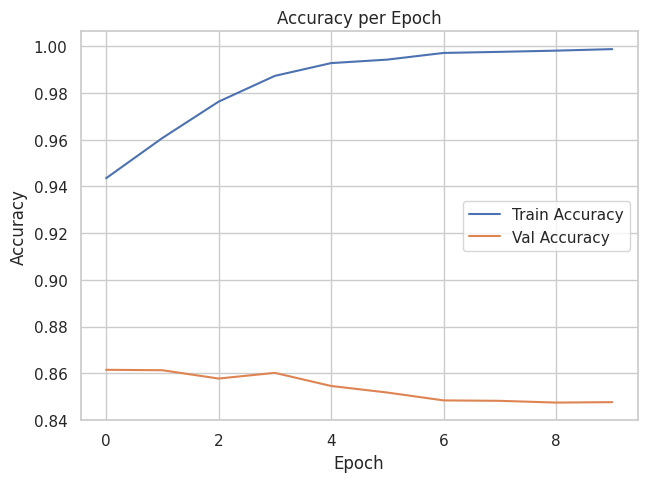

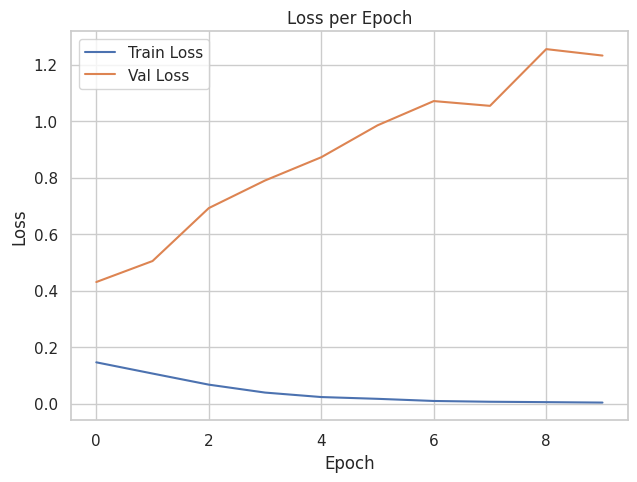

In [76]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8627    0.8662    0.8644      2996
           1     0.8282    0.8240    0.8261      2346

    accuracy                         0.8476      5342
   macro avg     0.8454    0.8451    0.8452      5342
weighted avg     0.8475    0.8476    0.8476      5342

AUC Score: 0.9179


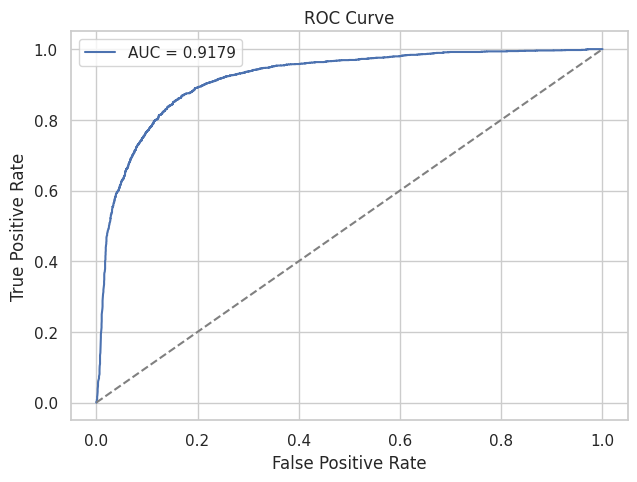

In [77]:
# Prediksi probabilitas dan kelas
y_pred_prob = best_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

# AUC Score
auc = roc_auc_score(y_val, y_pred_prob)
print(f"AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Proses Training Model GRU

In [78]:
from keras_tuner import HyperModel
from tensorflow.keras import layers, models, optimizers

class GRUHyperModel(HyperModel):
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Embedding(
            input_dim=10000,
            output_dim=hp.Int('embedding_dim', min_value=16, max_value=128, step=16),
            input_length=100
        ))
        model.add(layers.GRU(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True))
        model.add(layers.GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model


In [79]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    GRUHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='gru_tuning'
)


In [ ]:
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Trial 3 Complete [00h 33m 16s]
val_accuracy: 0.8554848432540894

Best val_accuracy So Far: 0.863347053527832
Total elapsed time: 01h 08m 39s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
80                |16                |embedding_dim
96                |32                |units
0.0093815         |0.0069406         |learning_rate

Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 132s 188ms/step - accuracy: 0.7675 - loss: 0.4911 - val_accuracy: 0.8474 - val_loss: 0.3519
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 120s 180ms/step - accuracy: 0.9136 - loss: 0.2156 - val_accuracy: 0.8255 - val_loss: 0.4256
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - accuracy: 0.9439 - loss: 0.1475 - val_accuracy: 0.8353 - val_loss: 0.4774
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 138s 178ms/step - accuracy: 0.9497 - loss: 0.1355 - val_accuracy: 0.8379 - val_loss: 0.4786
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 141s 177ms/step - accuracy: 0.9469 - loss: 0.1402 - val_accura

In [ ]:
# Ambil model terbaik dari tuner
best_gru_model = tuner.get_best_models(1)[0]

# Compile ulang model
best_gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit ulang untuk mendapatkan history (agar bisa divisualisasikan)
history = best_gru_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi probabilitas dan kelas
y_pred_prob = best_gru_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluasi metrik
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)

print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


In [ ]:
# Visualisasi akurasi dan loss
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### PyTorch

### Persiapan Awal PyTorch

In [ ]:
import numpy as np

X_train = np.load('X_latih_seq.npy')
X_test = np.load('X_uji_seq.npy')
y_train = np.load('y_latih.npy')
y_test = np.load('y_uji.npy')


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### RNN Models Dengan PyTorch

In [ ]:
import numpy as np

# Load data
X_latih = np.load('X_latih_seq.npy')
X_uji = np.load('X_uji_seq.npy')
y_latih = np.load('y_latih.npy')
y_uji = np.load('y_uji.npy')


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset custom
class ReviewDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.long)  # ubah ke tensor integer
        self.label = torch.tensor(label, dtype=torch.float32)  # ubah ke tensor float

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

# Buat dataset
train_dataset = ReviewDataset(X_latih, y_latih)
test_dataset = ReviewDataset(X_uji, y_uji)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### Bangun Model RNN PyTorch

In [ ]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)


### Inisialisasi Model, Loss, Optimizer

In [ ]:
# Param dasar
vocab_size = len(kamus_kata)
embedding_dim = 128
hidden_dim = 128

# Model, loss, optimizer
model_rnn = RNNClassifier(vocab_size, embedding_dim, hidden_dim)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)


### Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(output) >= 0.5).long()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                v_loss = loss_fn(val_output, y_val)
                val_loss += v_loss.item()
                val_preds = (torch.sigmoid(val_output) >= 0.5).long()
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
y_uji_tensor = torch.tensor(y_uji, dtype=torch.float32).to(device)
val_dataset = TensorDataset(X_uji_tensor, y_uji_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model_rnn, train_loader, val_loader, loss_fn, optimizer, epochs=30
)


### Evaluasi Model

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Konversi X_uji ke tensor
X_uji_tensor = torch.tensor(X_uji_seq, dtype=torch.long).to(device)

# Prediksi
model_rnn.eval()
with torch.no_grad():
    output = model_rnn(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi y_uji ke NumPy (pastikan ini NumPy array, bukan tensor)
y_true = y_uji if isinstance(y_uji, np.ndarray) else y_uji.values

# Evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

# Output hasil
print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")


In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN PyTorch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


---

### 📘 1. **Input ke Hidden State**
Untuk setiap time step $ t $, RNN menerima input $ x_t $ dan hidden state dari step sebelumnya $ h_{t-1} $, lalu menghitung hidden state sekarang $ h_t $:

$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Penjelasan**:
- $ x_t $: input di urutan ke-$ t $ (biasanya vektor embedding dari satu kata).
- $ h_{t-1} $: hidden state sebelumnya (memory dari urutan sebelumnya).
- $ W_{xh} $: bobot dari input ke hidden.
- $ W_{hh} $: bobot dari hidden sebelumnya ke hidden sekarang.
- $ b_h $: bias.
- $ \tanh $: fungsi aktivasi, bikin output tetap dalam range $-1$ sampai $1$ dan menambahkan non-linearitas.

---

### 📘 2. **Hidden State ke Output**
Setelah selesai memproses semua urutan, hidden state terakhir bisa digunakan untuk prediksi output (dalam kasus ini: klasifikasi biner).

$$
\hat{y} = \sigma(W_{hy}h_T + b_y)
$$

**Penjelasan**:
- $ h_T $: hidden state terakhir (setelah semua kata diproses).
- $ W_{hy} $: bobot dari hidden state ke output.
- $ b_y $: bias output.
- $ \sigma $: sigmoid function karena klasifikasinya biner, hasil antara 0 dan 1.

---

### 📘 3. **Loss Function**
Model pakai **Binary Cross Entropy Loss**, ini rumus umumnya:

$$
\mathcal{L} = - \left( y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right)
$$

**Penjelasan**:
- $ y $: label asli (0 atau 1).
- $ \hat{y} $: probabilitas prediksi model.
- Loss ini bikin prediksi makin "deket" ke label asli.

---

### 📘 4. **Backpropagation**
Di belakang layar, PyTorch menghitung turunan dari loss terhadap parameter model (misalnya $ W_{xh}, W_{hh}, W_{hy} $) dengan **backpropagation through time (BPTT)**.

---

### 🧠 Intuisi Singkat
- Di setiap step, RNN gabungin info baru (kata ke-$t$) dengan memory sebelumnya (hidden state).
- Setelah semua kata diproses, RNN punya *representasi* kalimat dalam bentuk $ h_T $, yang bisa dipakai untuk klasifikasi.
- Karena dia “recurrent”, memory bisa mengalir ke depan, cocok banget buat data sekuensial seperti review.

---

### Model LSTM Dengan PyTorch

In [ ]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden_state = lstm_out[:, -1, :]  # Ambil hidden state terakhir
        output = self.fc(final_hidden_state)
        return output


In [ ]:
# Parameter
vocab_size = len(kamus_kata)
embed_dim = 100
hidden_dim = 128

# Inisialisasi model
model_lstm = LSTMClassifier(vocab_size, embed_dim, hidden_dim).to(device)

# Loss dan optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.sigmoid(output) >= 0.5
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validasi
        model.eval()
        with torch.no_grad():
            val_loss, val_correct, val_total = 0, 0, 0
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                loss = loss_fn(val_output, y_val)
                val_loss += loss.item()

                val_preds = torch.sigmoid(val_output) >= 0.5
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"📚 Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model_lstm, train_loader, val_loader, loss_fn, optimizer, epochs=30
)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Akurasi Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Training & Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Pastikan data uji sudah jadi tensor
X_uji_tensor = torch.tensor(X_uji_seq, dtype=torch.long).to(device)
y_uji_tensor = torch.tensor(y_uji, dtype=torch.float).to(device)

# Prediksi
model_lstm.eval()
with torch.no_grad():
    output = model_lstm(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi y_true
y_true = y_uji_tensor.cpu().numpy()

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

# Tampilkan
print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")


In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


---

## 🔁 Struktur Dasar LSTM

LSTM punya **3 gerbang utama** yang mengatur aliran informasi:
1. **Forget Gate** 🧽
2. **Input Gate** ✍️
3. **Output Gate** 📤

Dan juga **cell state** `C_t` yang menyimpan memori jangka panjang.

---

### 🧠 Notasi:
- `x_t` = input saat waktu `t`
- `h_t` = hidden state saat waktu `t`
- `C_t` = cell state saat waktu `t`
- `W` dan `b` = bobot dan bias yang dilatih
- `σ` = sigmoid function
- `tanh` = hyperbolic tangent function
- `*` = elemen-wise multiplication

---

## 📘 Persamaan Matematika LSTM

---

### 1. **Forget Gate**  
Menentukan berapa banyak informasi lama yang perlu dilupakan dari `C_{t-1}`.

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- Fungsi sigmoid akan output antara 0–1
- Jika hasilnya 0 → buang semua memori lama
- Jika hasilnya 1 → pertahankan semua

---

### 2. **Input Gate**  
Menentukan berapa banyak informasi baru yang akan ditambahkan ke cell state.

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- `i_t` = seberapa penting informasi baru
- `\tilde{C}_t` = kandidat nilai baru yang akan ditambahkan ke cell state

---

### 3. **Update Cell State**

$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

- Ini kombinasi antara memori lama (`C_{t-1}`) dan informasi baru (`\tilde{C}_t`)
- Memungkinkan LSTM mempertahankan informasi jangka panjang

---

### 4. **Output Gate**

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$

- `o_t` memutuskan bagian mana dari cell state yang akan dikeluarkan
- `h_t` ini yang dikirim ke waktu berikutnya & output akhir

---

## 🧠 Di PyTorch

Kalau pakai `nn.LSTM`, semua ini sudah dibungkus secara internal:

```python
self.lstm = nn.LSTM(input_size=100, hidden_size=128, batch_first=True)
```

- **`input_size`** → ukuran vektor input tiap timestep
- **`hidden_size`** → dimensi dari `h_t` dan `C_t`
- PyTorch secara otomatis menyimpan dan update `C_t` dan `h_t` di dalam training loop

---

## 🔚 Output LSTM

```python
output, (h_n, c_n) = self.lstm(x)
```

- `output` → semua hidden state `h_t` untuk setiap timestep
- `h_n` → hidden state terakhir (biasanya ini yang dipakai untuk klasifikasi)
- `c_n` → cell state terakhir

---

### Model GRU dengan PyTorch

In [ ]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)


In [ ]:
import torch

# Konversi data latih dan label ke tensor
X_latih_tensor = torch.tensor(X_latih_seq, dtype=torch.long).to(device)
y_latih_tensor = torch.tensor(y_latih, dtype=torch.float32).to(device)


In [ ]:
vocab_size = int(torch.max(X_latih_tensor)) + 1
embed_dim = 128
hidden_dim = 128

model_gru = GRUModel(vocab_size, embed_dim, hidden_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (output >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validasi
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_output = model(X_val).squeeze()
                loss = loss_fn(val_output, y_val)
                val_loss += loss.item()

                val_preds = (val_output >= 0.5).float()
                val_correct += (val_preds == y_val).sum().item()
                val_total += y_val.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"📚 Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

# Training model
train_losses, val_losses, train_accs, val_accs = train_model(model_gru, train_loader, val_loader, loss_fn, optimizer, epochs=30)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model_gru.eval()
with torch.no_grad():
    output = model_gru(X_uji_tensor).squeeze()
    pred_probs = torch.sigmoid(output).cpu().numpy()
    y_pred = (pred_probs >= 0.5).astype(int)

# Konversi label ke numpy
y_true = y_uji_tensor.cpu().numpy()

# Evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, pred_probs)

print(f"📊 Akurasi: {acc:.4f}")
print(f"📊 Presisi: {prec:.4f}")
print(f"📊 Recall: {rec:.4f}")
print(f"📊 F1 Score: {f1:.4f}")
print(f"📊 AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'GRU (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend()
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Akurasi Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Training & Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


---

## 🔍 Arsitektur GRU

GRU adalah varian dari RNN yang menggabungkan dua **gate**:  
1. **Update Gate** `zₜ`  
2. **Reset Gate** `rₜ`

Tujuannya untuk mengatasi **vanishing gradient** dan membuat model **ingat informasi penting lebih lama**.

---

## 💡 Persamaan GRU

Misalkan:
- $ x_t $: input pada waktu ke-𝑡
- $ h_{t-1} $: hidden state sebelumnya
- $ h_t $: hidden state saat ini
- $ \sigma $: sigmoid activation
- $ \tanh $: hyperbolic tangent activation

---

### 1. **Update Gate** $ z_t $

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$

🔎 *Fungsi:* Mengontrol seberapa banyak informasi dari waktu sebelumnya ($ h_{t-1} $) yang akan dibawa ke waktu sekarang ($ h_t $).

---

### 2. **Reset Gate** $ r_t $

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$

🔎 *Fungsi:* Mengontrol seberapa banyak dari masa lalu yang akan dilupakan. Jika gate ini kecil → informasi lama di-*reset*.

---

### 3. **Candidate Activation** $ \tilde{h}_t $

$$
\tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
$$

🔎 *Fungsi:* Calon nilai hidden state baru. Dikalikan dulu dengan reset gate, agar hanya sebagian dari $ h_{t-1} $ yang dilanjutkan.

---

### 4. **Final Hidden State** $ h_t $

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

🔎 *Fungsi:* Kombinasi antara hidden state lama dan yang baru. Update gate $ z_t $ yang mengontrol pencampuran ini.

---

## 🧠 Intuisi Sederhana

- **Update gate**: “Apa yang harus saya simpan dari masa lalu?”
- **Reset gate**: “Apa yang harus saya lupakan dari masa lalu?”
- **Hidden state**: “Informasi baru yang disesuaikan dengan yang penting dari masa lalu.”

---

## 💻 Implementasi di PyTorch

Saat pakai `nn.GRU(...)`, semua persamaan di atas sudah dibungkus dan dioptimalkan di dalam PyTorch. Secara internal, ia melakukan hal seperti:

```python
self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
```

Itu otomatis menangani:
- perhitungan `z_t`, `r_t`, dan `h_t`
- unrolling waktu
- tracking gradien untuk backpropagation

---